# Competition Project : Classification of Sincere/Insincere Questions on Quora - Part 3

**Prepared by:** Daniel Han<br>
**Prepared for:** Brainstation

In [23]:
# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

### Load Data & Dependencies

##### Basic Libraries

In [24]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##### Plotly Visualization

In [64]:
import plotly.express as px

##### Gensim for Tokenization

In [25]:
# Import Genism library
import gensim

##### NLTK and SpaCy for Stopwords and Lemmatization

In [26]:
# The following code is only required if nltk packages are not already installed.
# import nltk
# nltk.download()

In [27]:
# Import libraries
from nltk.corpus import stopwords
# from nltk.stem import WordNetLemmatizer 
import spacy

In [28]:
# Loading stopwords from spacy
stopwords_spacy=spacy.load("en_core_web_sm").Defaults.stop_words

# Loading stopwords from NLTK
stopwords_nltk = stopwords.words('english')

# combining the stopword list
combined_stopwords = set((set(stopwords_spacy)|set(stopwords_nltk)))

In [29]:
# Create Lemmatizer from SpaCy Library
lemmatizer = spacy.load('en_core_web_sm', disable = ['parser','ner'])

In [30]:
# Create a custom tokenizer
def custom_tokenizer(text: str):
    
# Step 1 - Tokenization
    
    # tokenize given string using Gensim's preprocessor
    tokenized = gensim.utils.simple_preprocess(text) # This returns a list of strings
    
# Step 2 - Stopword Removal
    
    # Create an empty list of non-stopwords
    tokenized_no_stopwords = []

    # Loop over the tokenized list of strings and add only non-stopwords to the empty list above
    for i in tokenized:
        if i not in combined_stopwords:
            tokenized_no_stopwords.append(i) # At the end of this for loop, a list of strings is returned
    
# Step 3 - Lemmatization
    
    # Create an instance of SpaCy.Token.doc.Doc using the stopword-removed list of strings
    doc = lemmatizer(' '.join(tokenized_no_stopwords))
    
    # Create a final lsist, which should contain all lemmatized, non-stopwords, without any numerical or special characters.
    final_string = [token.lemma_ for token in doc]
    
    return final_string

##### Sci-kit Learn

In [31]:
# Import Sci-kit Learn Libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score, recall_score, f1_score
from sklearn.base import BaseEstimator, TransformerMixin

##### XGBoost

In [32]:
# Import XGBoost
from xgboost import XGBClassifier

##### Tensorflow & Keras

In [33]:
# pip install tensorflow-text

In [34]:
# pip install tensorflow-addons

In [35]:
# Import Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
import keras.backend as K

#### Load Data, Train-Test Split, Downsampling

In [36]:
# Read in csv
df_full = pd.read_csv('train.csv', index_col = 0)

In [37]:
# Keep 50 percent of data and discard rest
df, df_discard = train_test_split(df_full, test_size = 0.5, stratify = df_full['target'])

In [38]:
# Separate dataframe into dependant and independant variables
X = df.iloc[:, :-1]['question_text']
y = df.iloc[:, -1]

In [39]:
# Import train_test_split
from sklearn.model_selection import train_test_split

In [40]:
# Split into Train and Test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.2, stratify = y)

In [41]:
# Downsample class 0
X_downsampled, y_downsampled = resample(X_train_full[y_train_full == 0],
                                       y_train_full[y_train_full == 0],
                                       replace = True,
                                       n_samples = X_train_full[y_train_full == 1].shape[0])

In [42]:
# Concateneate downsampled class 0 with class 1
X_train = pd.concat((X_train_full[y_train_full == 1], X_downsampled))
y_train = np.hstack((y_train_full[y_train_full == 1], y_downsampled))

### 5.6 Deep Learning Approach

Following the standard machine learning algorithms, a neural network is constructed to solve the same classification problem, and the performances are compared. Due to the computing limitations, the original training model is reduced down such that the number of rows is approximately 10 times greater than the number of columns (i.e. 768, which will be discussed in a subsequent section), and the training of the deep learning model is computed once with 100 epochs.

#### 5.6.1 BERT Encoding

For the vectorization of the input, BERT is implemented. BERT is an encoder developed by Google. This encoder is the hidden layer of a deep neural network pretrained on the sentences on Wikipedia. BERT converts every document in the corpus to a vector of 768 dimensions. While similar to the Word2Vec encoder discussed earlier in the analysis, the BERT encoder is capable of holding the contextual meaning of a word that may have multiple meanings (e.g. fair). The APIs made available from Tensorflow are used, namely the BERT preprocesser (for tokenization) and BERT encoder (for embedding).

In [43]:
# Import BERT Preprocessor and Encoder
bert_preprocess = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
bert_encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

A function combining the preprocessor and encoder above can be created.

In [44]:
# Define a function that preprocesses and returns encoded vector for the entire document
def document_encoder(documents):
    return bert_encoder(bert_preprocess(documents))['pooled_output']

In [45]:
# Try some questions
document_encoder(['Why colour is the sky?', 'Where should I put my shoe?'])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.9435404 , -0.39288747, -0.7429049 , ..., -0.56953377,
        -0.75938034,  0.94859505],
       [-0.9071073 , -0.29177663, -0.32868326, ..., -0.15330811,
        -0.6633956 ,  0.95345896]], dtype=float32)>

#### 5.6.2 Neural Network Construction & Optimization

##### Neural Network Construction

Using the preprocessor and encoder above, a neural network is created. Specifically, Keras' functional API is used to construct the network. 

In [46]:
# Step 1 - Input Layers

# This layer converts X_train (which is a pd.Series object) to a tensor containing tf.string objects
text_input = keras.layers.Input(shape=(), dtype = tf.string, name = 'text') # Match the input shape by setting shape to ()
# This layer preprocesses text
preprocessed_text = bert_preprocess(text_input)
# This layer encodes preprocessed text
outputs = bert_encoder(preprocessed_text)


# Step 2 - Hidden Layers

# Dropout Layer
layer_1 = keras.layers.Dropout(0.2, name = 'Dropout_1')(outputs['pooled_output'])
# ReLU Activation Fuction
layer_2 = keras.layers.Dense(192, activation = 'relu', name = 'relu_1')(layer_1)
# Dropout Layer
layer_3 = keras.layers.Dropout(0.2, name = 'Dropout_2')(layer_2)
# ReLU Activation Fuction
layer_4 = keras.layers.Dense(92, activation = 'relu', name = 'relu_2')(layer_3)
# Dropout Layer
layer_5 = keras.layers.Dropout(0.2, name = 'Dropout_3')(layer_4)
# ReLU Activation Fuction
layer_6 = keras.layers.Dense(16, activation = 'relu', name = 'relu_3')(layer_5)


# Step 3 - Output layer

# Output Layer - Sigmoid Activation Function
layer_7 = keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(layer_6)


# Step 4 - Combine above layers to instantiate a machine learning model
model = keras.Model(inputs = [text_input], outputs = [layer_7])

In [47]:
# Step 5 - Set Metric
METRICS = [tf.keras.metrics.BinaryAccuracy(name = 'Accuracy')]


# Step 6 - Compile Model
model.compile(optimizer = 'adam', # Adam optimizer
             loss = 'binary_crossentropy', # Binary Cross Entropy Cost Function
             metrics = METRICS) # Accuracy is Binary Accuracy

Due to the computation limitations of the device, the train set is reduced such that the number of rows is 10 times larger that of the columns. This is approximately equal to one-tenth of the size of data. 

In [48]:
# Randomly select indices
indices = np.random.choice(np.arange(len(X_train)), size = 7680, replace = False)

# Reduce train set
X_train_reduced = X_train[indices]
y_train_reduced = y_train[indices]

Finally, the model constructed above is trained on the reduced train set.

In [49]:
# Step 7 - Declare an early stopping requirement such that if the loss does not increase after 10 epochs,
# The model fitting is terminated.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Step 8 - Fit Neural Network on the reduced data
model.fit(X_train_reduced, y_train_reduced, epochs = 100, callbacks = [callback])

Epoch 1/100
240/240 [==============================] - 1004s 4s/step - loss: 0.6344 - Accuracy: 0.6408
Epoch 2/100
240/240 [==============================] - 953s 4s/step - loss: 0.5353 - Accuracy: 0.7389
Epoch 3/100
240/240 [==============================] - 923s 4s/step - loss: 0.5000 - Accuracy: 0.7642
Epoch 4/100
240/240 [==============================] - 908s 4s/step - loss: 0.4735 - Accuracy: 0.7807
Epoch 5/100
240/240 [==============================] - 908s 4s/step - loss: 0.4699 - Accuracy: 0.7822
Epoch 6/100
240/240 [==============================] - 900s 4s/step - loss: 0.4664 - Accuracy: 0.7845
Epoch 7/100
240/240 [==============================] - 892s 4s/step - loss: 0.4614 - Accuracy: 0.7868
Epoch 8/100
240/240 [==============================] - 888s 4s/step - loss: 0.4589 - Accuracy: 0.7868
Epoch 9/100
240/240 [==============================] - 889s 4s/step - loss: 0.4598 - Accuracy: 0.7850
Epoch 10/100
240/240 [==============================] - 886s 4s/step - loss: 0.45

The neural network trained on the reduced dataset is tested on the test set to opimize the decision threshold.

##### Threshold Optimization

In [120]:
# Create a list of thresholds
threshold = np.arange(0.5, 1, 0.01)
f1_scores = []
y_prob = model.predict(X_test) # Compute probabilities of y-labels

In [121]:
y_prob.reshape(-1)

array([0.83560395, 0.05502254, 0.0219402 , ..., 0.55395925, 0.01960349,
       0.7839451 ], dtype=float32)

In [122]:
# For each threshold, compute the f1 score and append to the list of f1 scores under the ith key of f1_dict
for t in threshold:
    y_pred = np.where(y_prob >= t, 1, 0)
    f1_scores.append(f1_score(y_test, y_pred))

In [123]:
# Plot F1 Score vs Threshold

fig = px.line(x = threshold, y = f1_scores)
fig.update_layout(title = 'F1 Score on Imbalanced Data at Different Decision Thresholds<br>for Neural Network',
                 xaxis_title = 'Threshold',
                 yaxis_title = 'F1 Score')
fig.show()

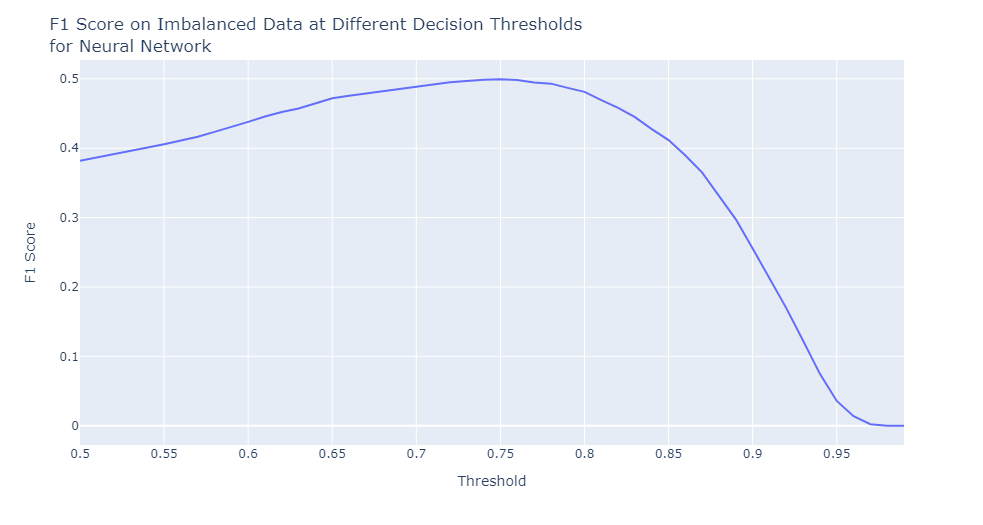

In [124]:
# Determine the optimal threshold, which is that corresponds to the maximum mean_f1_score
optimal_threshold = threshold[np.argmax(f1_scores)]

# Maximum mean F1 score
max_f1_score = max(f1_scores)

# Print Result
print(f'Max F1-Score : {round(max_f1_score, 3)}\nOptimal Threshold : {optimal_threshold}')

Max F1-Score : 0.499
Optimal Threshold : 0.7500000000000002


#### 5.6.3 Model Evaluation

Using the trained neural network and the optimal threshold, the performance of the model is evaluated.

In [125]:
# Prediction with new threshold
y_pred = np.where(y_prob >= optimal_threshold, 1, 0)

In [126]:
# Create confusion matrix with the hard prediction
cf_mat = confusion_matrix(y_test, y_pred)

# Create DataFrame with the confusion matrix
cf_mat_df = pd.DataFrame(cf_mat, index = ['True Sincere', 'True Insincere'], columns = ['Predicted Sincere', 'Predicted Insincere'])

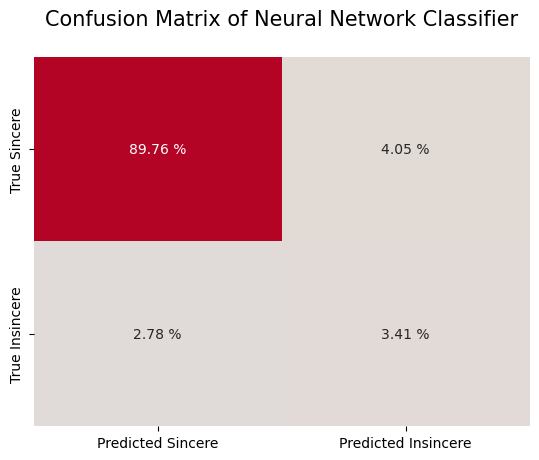

In [89]:
# Plot Confusion Matrix
plt.figure()
ax = sns.heatmap(cf_mat / len(y_test) * 100, annot = True, cmap = 'coolwarm', fmt='.2f', center = 0, cbar = False)
for t in ax.texts: t.set_text(t.get_text() + " %")
plt.title('Confusion Matrix of Neural Network Classifier\n', size = 15)
plt.xticks([0.5, 1.5], ['Predicted Sincere', 'Predicted Insincere'])
plt.yticks([0.5, 1.5], ['True Sincere', 'True Insincere'])
plt.show()

In [90]:
# Print Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96    122532
           1       0.46      0.55      0.50      8081

    accuracy                           0.93    130613
   macro avg       0.71      0.75      0.73    130613
weighted avg       0.94      0.93      0.93    130613



The F-1 Score of the model is 0.50 with the accuracy of 0.93.

### 5.7 Final Model Selection

#### 5.7.1 Model Comparison

The performances of the following two models, namely:

1. XGBoost Model with Tf-Idf matrix, and
2. Neural Network Model with BERT encoded matrix,

are summarized as shown below.

|Model / Vector | Accuracy | Precision | Recall | F-1 Score |
| --- | --- | --- | --- | --- |
|**XGB/Tf-Idf**| 0.94 | 0.48 | 0.59 | 0.53 |
|**NN/BERT**| 0.93 | 0.46 | 0.55 | 0.50|

The XGBoost model with Tf-Idf vectorized input performed better than Neural Network trained with BERT encoded input in all four metrics : accuracy, precision, recall and F-1 Score.

While considering that the neural network was trained on a dataset approximately 10 times smaller than XGBoost the performance is impressive, the XGBoost option returned a higher F-1 Score and significantly shorter run time therefore is selected as the final model.

#### 5.7.2 Prediction

The submission set (i.e. without target label) is predicted with the XGBoost classifier and inferences are made. First the model is imported.

In [92]:
# Load
pipe_xgb = joblib.load('pipe_xgb_joblib')

In [93]:
pipe_xgb

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(min_df=0.00125, ngram_range=(1, 3),
                                 tokenizer=<function custom_tokenizer at 0x0000020A07FB8430>)),
                ('xgb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, enable_categorical=False,
                               gamma=0, gpu_id=-1, importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=9, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, predictor='auto',
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, 

In [94]:
# Import submission set
df_submission = pd.read_csv('test.csv')

# Display 5 rows
df_submission.head()

,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [95]:
# Extract X
X_submission = df_submission['question_text']

In [96]:
# Predict Probabilities of submission set
y_prob = pipe_xgb.predict_proba(X_submission)

In [97]:
# Prediction with new threshold
y_pred = np.where(y_prob >= optimal_threshold, 1, 0)

#### 5.7.3 Inference

To review the decisions made by the prediction models, 10 questions predicted as sincere and insincere are randomly reviewed.

In [111]:
pd.set_option("display.max_colwidth", -1)

##### Sincere Questions

In [116]:
# Randomly sample 10 sincere questions
X_submission[y_pred[:,1] == 0].sample(10)

92462     What is the biggest ruse you have been able to pull off?                                                   
175945    What are the pros and cons of Travel agency?                                                               
145555    Will Mr. Potato Head get another TV show?                                                                  
219437    Is setting up a British food shop a good Idea in America?                                                  
137478    How can companies embrace speed?                                                                           
320075    I´m in the US with an o3 Visa, what´s the best way to change my visa status and being able to work legally?
210124    What was the most disturbed patient you've seen working in a psychiatric hospital?                         
185639    How many days it vil b take Jaipur to Trivandrum?                                                          
216448    Who was Mattie Moss Clark?                    

##### Insincere Questions

In [114]:
# Randomly sample 10 insincere questions
X_submission[y_pred[:,1] == 1].sample(10)

295584    Why do Indians abandon their own soldiers and claim that Chinese PLA are their own soldiers who kicked Indian soldiers at Ladakh in 2017?                                                                                               
275093    Why does a man hit a women?                                                                                                                                                                                                             
64013     Do girls in JEE coaching institutes seduce their male teachers (as claimed by many Quorans)?                                                                                                                                            
108081    Why do Tamils and other southern states hate or rather resist speaking in Hindi even though we all belong to the same nation?                                                                                                           
170516    Why didn’t Hillary

* Note : The precision of this prediction model is approximately 0.5. In other words, of the 10 questions classified as insincere above, roughly 5 questions could in fact be sincere. By personally reviewing the questions, however, it is difficult to distinguish which are sincere. Considering this, the prediction model is deemed to perform as well as a human can.